In [1]:
import sqlite3
import pandas as pd

Connecting to database

In [2]:
sqlite_file = 'lahman_1871-2022.sqlite'
conn = sqlite3.connect(sqlite_file)

**Part 1**

This code creates the query for the data and generates the resulting dataframe.

In [98]:
query = """
    SELECT
        t.teamID,
        t.yearID,
        t.franchID,
        t.Ghome,
        t.W,
        t.G,
        SUM(s.salary) AS total_payroll,
        CAST(t.W AS FLOAT) / t.G * 100 AS winning_percentage,
        CAST(SUM(s.salary) AS FLOAT) / t.Ghome AS payroll_per_game
    FROM
        Teams t
    JOIN
        Salaries s ON t.teamID = s.teamID AND t.yearID = s.yearID
    WHERE
        t.Ghome IS NOT NULL
        AND t.W IS NOT NULL
        AND t.G IS NOT NULL
        AND s.salary IS NOT NULL
        AND t.yearID BETWEEN 1990 AND 2022
    GROUP BY
        t.teamID,
        t.yearID,
        t.franchID,
        t.Ghome,
        t.W,
        t.G;
"""


df = pd.read_sql(query, conn)

for index, row in df.iterrows():
  if (row['total_payroll'] is None) or (row['winning_percentage'] is None):
    df = df.drop(index)


df = df.reset_index(drop=True)
df = df.drop(columns=['teamID'])
print(df)

     yearID franchID  Ghome   W    G  total_payroll  winning_percentage  \
0      1997      ANA     82  84  162     31135472.0           51.851852   
1      1998      ANA     81  85  162     41281000.0           52.469136   
2      1999      ANA     81  70  162     55388166.0           43.209877   
3      2000      ANA     81  82  162     51464167.0           50.617284   
4      2001      ANA     81  75  162     47535167.0           46.296296   
..      ...      ...    ...  ..  ...            ...                 ...   
783    2012      WSN     81  98  162     80855143.0           60.493827   
784    2013      WSN     81  86  162    113703270.0           53.086420   
785    2014      WSN     81  96  162    131983680.0           59.259259   
786    2015      WSN     81  83  162    155587472.0           51.234568   
787    2016      WSN     81  95  162    141652646.0           58.641975   

     payroll_per_game  
0        3.797009e+05  
1        5.096420e+05  
2        6.838045e+05  
3  

**Part 2**

In [5]:
import matplotlib.pyplot as plt

*Problem 2*

Generating a scatterplot for all teams' payrolls from 1990-2016.

Text(0, 0.5, 'Team Payroll (in Hundreds of Millions)')

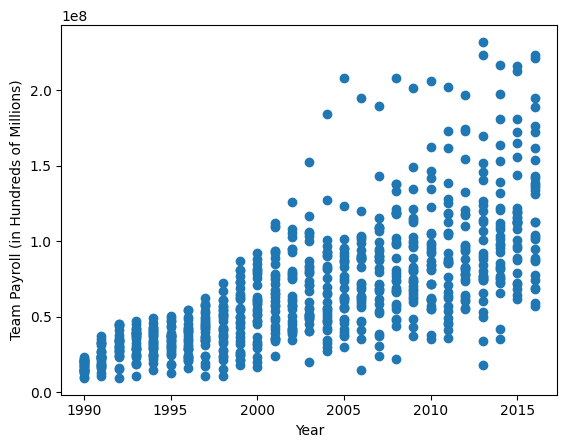

In [99]:
x = df['yearID'].values.tolist()
y = df['total_payroll'].values.tolist()

plt.scatter(x, y)
plt.xlabel('Year')
plt.ylabel('Team Payroll (in Hundreds of Millions)')

*Question 1*

The data for all teams shows that while the mean payroll appears to be steadily increasing, the variance has undergone a vast increase, from very closely clustered payroll amounts in 1990 to a widely varying spread in 2016.

*Problem 3*

Generating lists of the years analyzed, the mean total payrolls for each year, and the payroll standard deviation.

In [100]:
years = []
means = []
stdev = []
for i in range(1990, 2017):
  years.append(i)

  one_year_df = df[df['yearID'] == i]
  mean = one_year_df['total_payroll'].mean()
  means.append(mean)

  s = one_year_df['total_payroll'].std()
  stdev.append(s)

Generating graph of mean payroll

Text(0, 0.5, 'Mean Payroll (USD in Hundreds of Millions)')

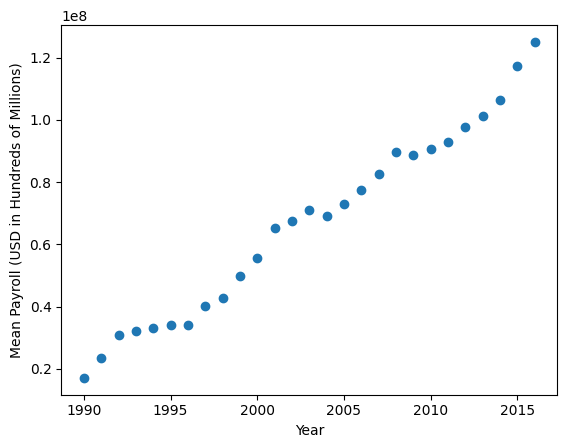

In [101]:
plt.scatter(years, means)
plt.xlabel('Year')
plt.ylabel('Mean Payroll (USD in Hundreds of Millions)')

Generating graph of payroll standard deviation

Text(0, 0.5, 'Standard Deviation of Payroll (USD in Tens of Millions)')

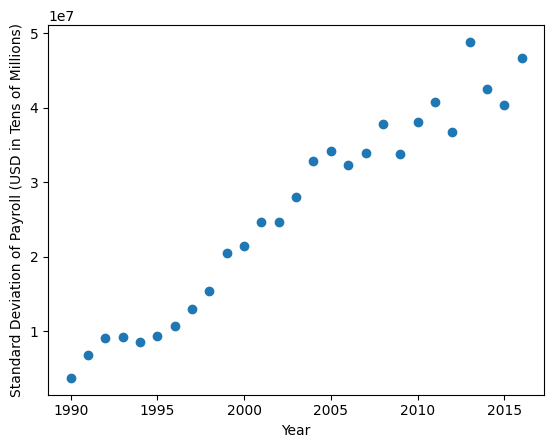

In [102]:
plt.scatter(years, stdev)
plt.xlabel('Year')
plt.ylabel('Standard Deviation of Payroll (USD in Tens of Millions)')

*Problem 4*

Adding a column to the dataframe showing 5 year time periods

In [103]:
time_periods = [1990, 1995, 2000, 2005, 2010, 2017]
labels = ['1990-1995', '1995-2000', '2000-2005', '2005-2010', '2010-2016']

df['time_period'] = pd.cut(df['yearID'], bins=time_periods, labels=labels, right=False)

tlist = df['franchID'].tolist()

# Removing duplicates
tset = set(tlist)

tlist = list(tset)

Getting mean payroll for each team in a time period

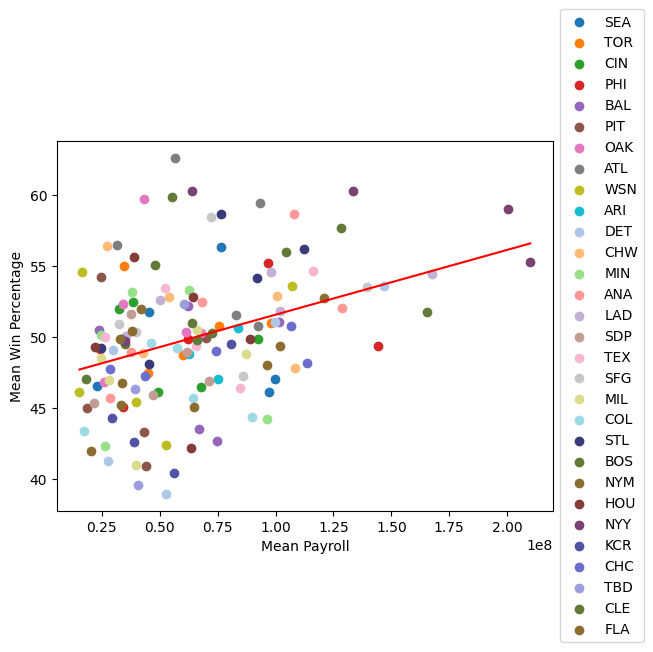

In [104]:
import numpy as np
import copy

custom_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
                 '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8', '#ffbb78', '#98df8a', '#ff9896',
                 '#c5b0d5', '#c49c94', '#f7b6d2', '#c7c7c7', '#dbdb8d', '#9edae5', '#393b79',
                 '#637939', '#8c6d31', '#843c39', '#7b4173', '#5254a3', '#6b6ecf', '#9c9ede',
                 '#637939', '#8c6d31'] # Colors to use for legend

mean_payrolls = []
mean_winpct = []

legend_added = set()
for i, team in enumerate(tlist):
  team_df = df[df['franchID'] == team]

  labels_to_use = copy.deepcopy(labels)

  if team == 'ARI' or team == 'TBD':
    labels_to_use.remove('1990-1995')
    labels_to_use.remove('1995-2000')
    # Removes the 1990-1995 and 1995-2000 periods from the Arizona Diamondbacks and Tampa Bay Rays, as both franchises were founded in 1998

  for period in labels_to_use:
    period_df = team_df[team_df['time_period'] == period]
    pay = period_df['total_payroll'].mean()
    mean_payrolls.append(pay)

    pct = period_df['winning_percentage'].mean()
    mean_winpct.append(pct)

    plt.scatter(pay, pct, label=team if team not in legend_added else None, color=custom_colors[i])
    legend_added.add(team) # Making sure the same team doesn't appear twice on the legend

# The following creates a line of best fit for the data
slope, intercept = np.polyfit(mean_payrolls, mean_winpct, 1)

line_x = np.linspace(min(mean_payrolls), max(mean_payrolls), 1000)
line_y = slope*line_x + intercept

plt.plot(line_x, line_y, color='Red')
x_label = 'Mean Payroll'
y_label = 'Mean Win Percentage'
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

*Question 2*

There does appear to be a moderate correlation between spending and win percentage.  Teams successful at winning for cheap would be closer to the upper left corner of the graph (low mean payroll, high mean wins).  The Oakland A's tend to land near that corner, with one particularly efficient period (presumably the 2000-2005 period in which Moneyball takes place).  The Atlanta Braves can be seen with a high win/low-payroll time period, and the Boston Red Sox have multiple points in that region (although they have actually reversed that trend in more recent seasons, as seen with a couple of their dots falling further to the right).

**Part 3**

*Problem 5*

Setting up a DataFrame with yearly means and standard deviations

In [105]:
year_stats = pd.DataFrame()

year_stats['Year'] = years
year_stats['Mean Payroll'] = means
year_stats['Payroll Standard Deviation'] = stdev
year_stats = year_stats.set_index('Year')

Adding a column showing standardized payroll, whch is equal to the difference between actual payroll for a given team and season, and mean payroll for that season, divided by the standard deviation of the actual payroll that season.

In [106]:
for index, row in df.iterrows():
  p = row['total_payroll']
  m = year_stats.at[row['yearID'], 'Mean Payroll']
  s = year_stats.at[row['yearID'], 'Payroll Standard Deviation']
  df.at[index, 'Standardized Payroll'] = (p - m)/s

*Problem 6*

Similar to the code that plotted mean payroll for 5 year time periods, this block of code plots mean standardized payroll across 5 year time periods.

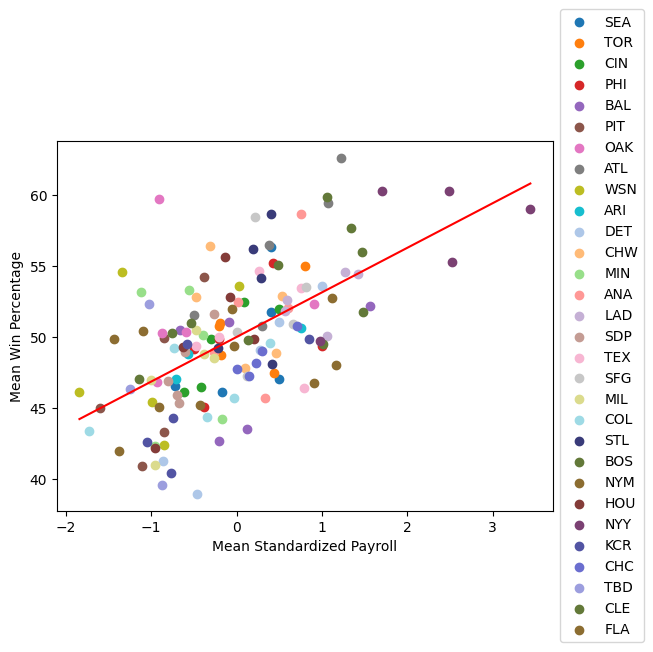

In [107]:
st_payrolls = []

legend_added = set()
for i, team in enumerate(tlist):
  team_df = df[df['franchID'] == team]

  labels_to_use = copy.deepcopy(labels)

  if team == 'ARI' or team == 'TBD':
    labels_to_use.remove('1990-1995')
    labels_to_use.remove('1995-2000')
    # Removes the 1990-1995 and 1995-2000 periods from the Arizona Diamondbacks and Tampa Bay Rays, as both franchises were founded in 1998

  for period in labels_to_use:
    period_df = team_df[team_df['time_period'] == period]
    pay = period_df['Standardized Payroll'].mean()
    st_payrolls.append(pay)

    pct = period_df['winning_percentage'].mean()

    plt.scatter(pay, pct, label=team if team not in legend_added else None, color=custom_colors[i])
    legend_added.add(team)

slope, intercept = np.polyfit(st_payrolls, mean_winpct, 1)

line_x = np.linspace(min(st_payrolls), max(st_payrolls), 1000)
line_y = slope*line_x + intercept

plt.plot(line_x, line_y, color='Red')
x_label = 'Mean Standardized Payroll'
y_label = 'Mean Win Percentage'
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

*Question 3*

On this graph, teams' data points tend to be more clustered.  The A's points all still tend toward the uppet left, but it's easier to see the efficiency of other teams such as the Minnesota Twins and Chicago White Sox, as their points can be found within a narrow vicinity of one another.  The New York Yankees, meanwhile, appear to have many of their points close to the top right corner.  

*Problem 7*

For each team and season, plotting standardized payroll (x) against win percentage (y), with a line of best fit.

Text(0, 0.5, 'Win Percentage')

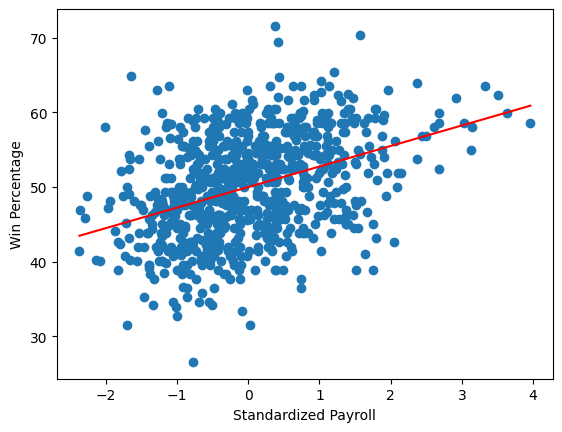

In [108]:
wpct = df['winning_percentage'].values.tolist()
spay = df['Standardized Payroll'].values.tolist()

plt.scatter(spay, wpct)

slope, intercept = np.polyfit(spay, wpct, 1)

line_x = np.linspace(min(spay), max(spay), 1000)
line_y = slope*line_x + intercept

plt.plot(line_x, line_y, color='Red')
x_label = 'Standardized Payroll'
y_label = 'Win Percentage'
plt.xlabel(x_label)
plt.ylabel(y_label)

*Problem 8*

Adding an "efficiency" column to our dataframe, which shows the difference between a team's actual win percentage, and its expected win percentage as calculated using the line of best fit shown above.

In [109]:
for index, row in df.iterrows():
  expect = slope*df.at[index, 'Standardized Payroll'] + intercept
  actual = df.at[index, 'winning_percentage']

  df.at[index, 'Efficiency'] = actual - expect

Creating a new DataFrame consisting of data from just 5 teams: the Oakland A's, New York Yankees, Boston Red Sox, Atlanta Braves, and Tampa Bay Rays.

In [110]:
teams_to_keep = ['OAK', 'NYY', 'BOS', 'ATL', 'TBD']

narrowed_df = df[df['franchID'].isin(teams_to_keep)]

print(narrowed_df)

     yearID franchID  Ghome    W    G  total_payroll  winning_percentage  \
27     1990      ATL     81   65  162     14555501.0           40.123457   
28     1991      ATL     81   94  162     18403500.0           58.024691   
29     1992      ATL     81   98  162     34625333.0           60.493827   
30     1993      ATL     81  104  162     41641417.0           64.197531   
31     1994      ATL     55   68  114     49383513.0           59.649123   
..      ...      ...    ...  ...  ...            ...                 ...   
717    2012      TBD     81   90  162     64173500.0           55.555556   
718    2013      TBD     81   92  163     52955272.0           56.441718   
719    2014      TBD     81   77  162     72689100.0           47.530864   
720    2015      TBD     84   80  162     64521233.0           49.382716   
721    2016      TBD     81   68  162     57097310.0           41.975309   

     payroll_per_game time_period  Standardized Payroll  Efficiency  
27      179697.54

Generating a line graph of the 5 specified teams' efficiency each year.

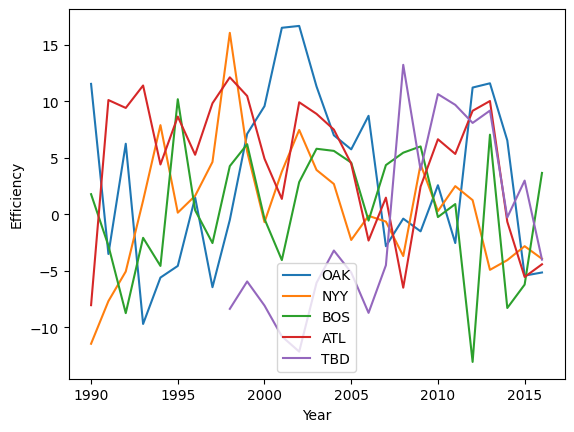

In [111]:
mean_payrolls = []
mean_winpct = []

for team in teams_to_keep:
  team_df = narrowed_df[narrowed_df['franchID'] == team]
  exps = team_df['Efficiency'].values.tolist()

  if team == 'TBD':
    years_to_use = [i for i in range(1998, 2017, 1)] # Removing 1990-1997 from the Tampa Bay Rays' data, as they did not exist during that time
  else:
    years_to_use = years


  plt.plot(years_to_use, exps, label=team)

x_label = 'Year'
y_label = 'Efficiency'
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()

*Question 4*

The above line chart paints a much clearer picture of the relationship between expected win percentage (based on payroll) and actual win percentage.  Oakland hit the highest efficiency level seen on this graph during the moneyball period, operating over 15 percentage points above expectation.  Making their run even more impressive, their efficiency remained at a similarly high level for multiple consecutive seasons, an achievement none of the other teams shown can claim, as the only other team to come close to the A's level of efficiency, the Yankees in the late 1990's, only stayed at that level for one season.